# Plots for the 2MDM analysis

In [32]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from auxPlots import columnsDict, colorDict, defaultPars

pd.option_context('display.max_columns', None)
pd.option_context('display.max_rows', None)

pd.options.mode.chained_assignment = None #Disable copy warnings
plt.rcParams.update(defaultPars) #Figure resolution

#### Get data in pcl format and print all columns names

In [54]:
#Merge with SModelS DataFrame
pclFile = '../data/smodels_results.pcl'
dataDF = pd.read_pickle(pclFile)
dataDF.rename(columns=columnsDict,inplace=True)
dropCols = [c for c in dataDF.columns if ('Output' in c or 'weight' in c)]
dataDF.drop(columns=dropCols,inplace=True)
print(dataDF.columns.values.tolist()) #Print all columns names

['maxcond', 'theory prediction (fb)', 'upper limit (fb)', 'expected upper limit (fb)', 'TxNames', 'Mass (GeV)', 'AnalysisID', 'DataSetID', 'AnalysisSqrts (TeV)', 'lumi (fb-1)', 'dataType', 'r', 'r_expected', 'Width (GeV)', 'nll', 'nll_min', 'nll_SM', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'mChi', 'mS', 'mZp', 'mass.9000002', 'mass.9000003', 'mass.9000004', 'mass.9000005', 'width.9000002', 'width.9000003', 'width.9000004', 'width.9000005', 'width.9000006', 'width.9900026', 'width.9900032', 'gchi', 'gq', 'sina', 'extpar.4', 'xsec8TeV(fb).9900032', 'xsec8TeV(fb).9900026', 'xsec13TeV(fb).9900032', 'xsec13TeV(fb).9900026', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.chi,chi', 'BRs.sd.ta+,ta-', 'BRs.zp.chi,chi', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.b,b', 'BRs.zp.t-,t+', 'BRs.sd.t-,t+', 'totalxsec13TeV

#### Set r = 0 for points with no results 

In [55]:
#Set points without results with r == 0
dataDF.fillna(value={'r' : 0}, inplace=True)
dataDF.sort_values(by='r',ascending=False,inplace=True)

#### Define exclusions

In [57]:
# Add simple flag for excluded points:
# Compute a series with index = filename and value = max(r) for each filename
excludedLHC = dataDF.groupby(level='filename',sort=False).apply(lambda grp: grp['r'].max() > 1.0)
# Set the excludedLHC column mapping the filename index in excludedLHC to the index in dataDF:
dataDF['excludedLHC'] = pd.Series(dataDF.index.get_level_values('filename')).map(excludedLHC).values

### Get points excluded:

In [58]:
excluded = dataDF[dataDF['excludedLHC'] == True]

allowed = dataDF[(dataDF['excludedLHC'] == False)]


print('Total number of points = %i' %len(dataDF.groupby(level='filename')))
print('Total excluded (LHC) = %i'%(len(excluded.groupby(level='filename'))))
print('Total allowed = %i\n'%(len(allowed.groupby(level='filename'))))


Total number of points = 21000
Total excluded (LHC) = 9946
Total allowed = 11054



#### Filter couplings

In [38]:
dataDF = dataDF[((dataDF['gchi'] == 0.01) & (dataDF['gq'] == 0.1) & (dataDF['sina'] == 0.25)) 
                | ((dataDF['gchi'] == 0.01) & (dataDF['gq'] == 0.15) & (dataDF['sina'] == 0.25))]

# Plot Results for Resonance Searches

In [39]:
allAnas = ['ATLAS-EXOT-2019-03', 'ATLAS-EXOT-2013-11', 'CMS-EXO-19-012', 
           'ATLAS-EXOT-2018-48', 'CMS-EXO-12-059', 'CMS-EXO-20-008', 
           'CMS-EXO-16-057']

#### Create legend for plots for excluded points

In [40]:
legend = [mpatches.Patch(color=color, label=ana) for ana,color in colorDict.items()]

### Plot only excluded points for a selected $g_{q}, g_{\chi}$ pair

### Separate between dijet and heavy flavors

In [41]:
dijAnas = ['ATLAS-EXOT-2019-03', 'CMS-EXO-19-012', 'CMS-EXO-12-059', 'ATLAS-EXOT-2013-11']
otherAnas = ['ATLAS-EXOT-2018-48', 'CMS-EXO-20-008', 'CMS-EXO-16-057']

In [42]:
# Figure parameters
xlim = (-150, 3000)
ylim = (0, 4.0)
gq_textpos = (0.05 , 0.5)

gq_textposB = (0.55, 0.5)

proc_pos = (0.1,0.92)

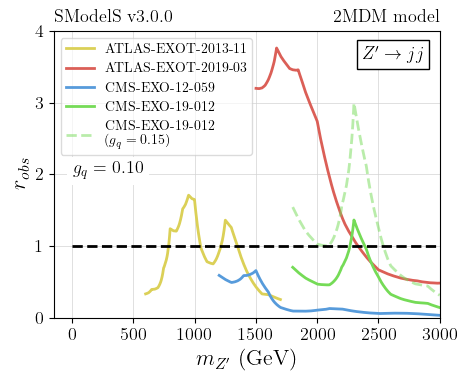

In [67]:
gq = 0.10
gchi = 0.01

anaGroups = dataDF.groupby('AnalysisID')
for ana,anadf in anaGroups:
    if ana not in dijAnas:
        continue
    # Select gchi and gq
    data = anadf[(anadf['gchi']==gchi) & (anadf['gq']==gq)]
    # Sort by r, so highest value comes first
    data = data.sort_values(by='r',axis=0,ascending=False)
    # Keep only the strongest result for a given analysis (first entry)
    data = data.groupby(level='filename').first()
    data = data.sort_values(by=['mZp'],axis=0)

    if len(data) == 0: continue
    x = data['mZp']
    y = data['r']
    label = ana
    pl = plt.plot(x, y, '-', label=label, c=colorDict[label])
    
gq_2 = 0.15
gchi_2 = 0.01
for ana,anadf in anaGroups:
    if ana not in dijAnas:
        continue
    data = anadf[(anadf['gchi']==gchi_2) & (anadf['gq']==gq_2)]
    # Sort by r, so highest value comes first
    data = data.sort_values(by='r',axis=0,ascending=False)
    # Keep only the strongest result for a given analysis (first entry)
    data = data.groupby(level='filename').first()

    data = data.sort_values(by=['mZp'],axis=0)
    # Keep only the strongest result for a given analysis:
    # data = data.groupby(level='filename')['r'].max()
    if len(data) == 0: continue
    x = data['mZp']
    y = data['r']
    label = ana
    pl2 = plt.plot(x, y, '--', label=label+'\n'+r' ($g_{q} = %1.2f$)' %(gq_2), c=colorDict[label], alpha=0.5)

    

plt.hlines(1, 0, 3000, linestyles='--', color='black')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$r_{obs}$')
plt.title(r'SModelS v3.0.0', loc='left')
plt.title(r'2MDM model', loc='right')

plt.xlim(*xlim)
plt.ylim(*ylim)

plt.text(*gq_textpos,r'$g_{q} = %1.2f$' %(gq),
         bbox=dict(facecolor='white', edgecolor='none'),transform = plt.gca().transAxes)
plt.legend(loc='upper left', framealpha=0.7)

plt.text(0.8,0.9,r'$Z^\prime \to jj$',
            bbox=dict(facecolor='white', edgecolor='black'),
            transform = plt.gca().transAxes)

plt.tight_layout()
plt.savefig('./figures/exclusions_2mdm_resonance_dijet.png')
plt.show()


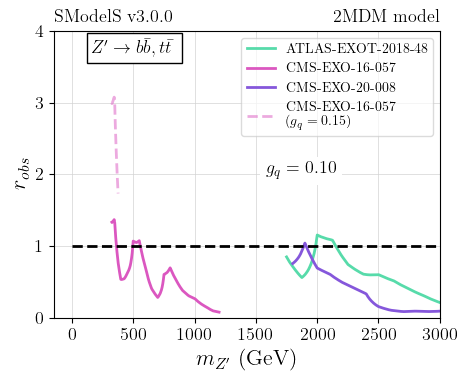

In [69]:
gq = 0.10
gchi = 0.01

anaGroups = dataDF.groupby('AnalysisID')
for ana,anadf in anaGroups:
    if ana not in otherAnas:
        continue
    # Select gchi and gq
    data = anadf[(anadf['gchi']==gchi) & (anadf['gq']==gq)]
    # Sort by r, so highest value comes first
    data = data.sort_values(by='r',axis=0,ascending=False)
    # Keep only the strongest result for a given analysis (first entry)
    data = data.groupby(level='filename').first()
    data = data.sort_values(by=['mZp'],axis=0)

    if len(data) == 0: continue
    x = data['mZp']
    y = data['r']
    label = ana
    pl = plt.plot(x, y, '-', label=label, c=colorDict[label])
    
gq_2 = 0.15
gchi_2 = 0.01
for ana,anadf in anaGroups:
    if ana not in otherAnas:
        continue
    # Select gchi and gq
    data = anadf[(anadf['gchi']==gchi_2) & (anadf['gq']==gq_2)]
    # Sort by r, so highest value comes first
    data = data.sort_values(by='r',axis=0,ascending=False)
    # Keep only the strongest result for a given analysis (first entry)
    data = data.groupby(level='filename').first()
    data = data.sort_values(by=['mZp'],axis=0)

    if len(data) == 0: continue
    x = data['mZp']
    y = data['r']
    label = ana
    pl2 = plt.plot(x, y, '--', label=label+'\n'+r' ($g_{q} = %1.2f$)' %(gq_2), c=colorDict[label], alpha=0.5)

    

plt.hlines(1, 0, 3000, linestyles='--', color='black')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$r_{obs}$')

plt.title(r'SModelS v3.0.0', loc='left')
plt.title(r'2MDM model', loc='right')

plt.xlim(*xlim)
plt.ylim(*ylim)


plt.text(*gq_textposB,r'$g_{q} = %1.2f$' %(gq),
         bbox=dict(facecolor='white', edgecolor='none'),transform = plt.gca().transAxes)
plt.legend(loc='upper right', framealpha=0.7)

plt.text(*proc_pos,r'$Z^\prime \to b\bar{b},t\bar{t}$',
            bbox=dict(facecolor='white', edgecolor='black'),
            transform = plt.gca().transAxes)

plt.tight_layout()
plt.savefig('./figures/exclusions_2mdm_resonance_heavyF.png')
plt.show()
